In [763]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la

In [779]:
#Constants
M = 300
R= 10
T=2
N=10000
sigma= 1/5 
r= 0.02
c=1
K_eur=10
H_eur=0
K_but = 1
H_but = 3
K_bin = 1
H_bin = 3

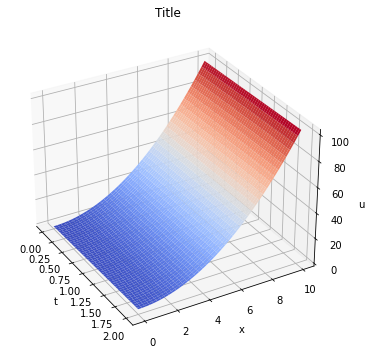

In [780]:
v_forward, CFL_forward = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
plot_solution(v_forward, angle=-30, title="Title")

In [712]:
#Practical function
def tridiag(lower, diag, upper, size):
    return np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)

### Initial Conditions function

In [153]:
def european_put(x):
    europe=np.array(K_eur-x)
    europe[int((K_eur*M)/R):]=0
    return europe

def butterfly(x):
    term1=np.array(x-K_but) #First term
    for i in range(len(term1)):
        term1[i] = max(term1[i], 0)
    term2=np.array(x-(K_but+H_but)) #Second term
    for i in range(len(term2)):
        term2[i] = max(term2[i], 0)
    term3=np.array(x-(K_but+2*H_but)) #Third term
    for i in range(len(term3)):
        term3[i] = max(term3[i], 0)
    butterfly=term1-2*term2+term3
    return butterfly

def binary(x, strike_K, strike_H, R, M):
    arr=np.ones(len(x))
    indices=np.where(x-strike_K<0)
    np.put(arr, indices, 0)
    return arr

#### Boundary conditions

In [396]:
def boundary_0(t=None, u_0=K_eur, x=None):  
    return u_0*np.exp(-c*t)

def boundary_R_eur(R, x=None, t=None):
    return max((K_eur-R), 0)

def boundary_R_but(R, x=None, t=None):
    butterfly=max(R-K_but, 0) - 2*max((R-(K_but+H_but)), 0) + max((R-(K_but+2*H_but)), 0)
    return butterfly

def boundary_R_bin(R, x=None, t=None):
    if (R-K_bin)<0:
        return 0
    else:
        return 1

#### Plotting functions

In [603]:
def plot_solution(U, angle=-30, title="Title"):        
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, R, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

In [637]:
def plot_two_solutions(U1, U2, angle=-30, title1="nr1", title2="nr2", title="Title"):   
    x1=np.linspace(0, R, len(U1[:,])) 
    t1=np.linspace(0, T, len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R, len(U2[:,])) 
    t2=np.linspace(0, T, len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

In [690]:
def plot_three_solutions(U1, U2, U3, angle=-30, title1="nr1", title2="nr2", title3="nr3", title="Title"):   
    x1=np.linspace(0, R, len(U1[:,])) 
    t1=np.linspace(0, T, len(U1[0]))
    tt1, xx1 = np.meshgrid(t1, x1)
    x2=np.linspace(0, R, len(U2[:,])) 
    t2=np.linspace(0, T, len(U2[0]))
    tt2, xx2 = np.meshgrid(t2, x2)
    x3=np.linspace(0, R, len(U3[:,])) 
    t3=np.linspace(0, T, len(U3[0]))
    tt3, xx3 = np.meshgrid(t3, x3)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), subplot_kw={"projection": "3d"})
    ax[0].plot_surface(tt1, xx1, U1, cmap=cm.coolwarm)
    ax[0].view_init(azim=angle)
    ax[0].set_title(title1)
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].plot_surface(tt2, xx2, U2, cmap=cm.coolwarm)
    ax[1].view_init(azim=angle)
    ax[1].set_title(title2)
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    ax[2].plot_surface(tt3, xx3, U3, cmap=cm.coolwarm)
    ax[2].view_init(azim=angle)
    ax[2].set_title(title3)
    ax[2].set_xlabel('t')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

### Forward Euler

In [547]:
def forward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1, N+1))       
    x=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x) #Initial and boundary functions
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    beta_0 = 1-k*sigma**2*m**2 - k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    F = RHS_func(x,t)[1:-1,:]
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1] #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    
    A=tridiag(beta_neg1[2:-1], beta_0[1:-1] ,beta_1[1:-2], M-1)
    
    CFL=min(np.diag(A))
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n]) + G[:,n] + k*F[:,n]
    
    return U, CFL

### Forward euler with Neuman BC

We now need an extra node to acheive second order consistency, $U_{M+1}$.

In [598]:
def forward_euler_neuman(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+2, N+1))       
    x=np.linspace(0, R, M+2)    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x) #Initial and boundary functions
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    beta_0 = 1-k*sigma**2*m**2 - k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    F = RHS_func(x,t)[1:-1,:]
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1] #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    
    A=tridiag(beta_neg1[2:-1], beta_0[1:-1] ,beta_1[1:-2], M-1)
    
    CFL=min(np.diag(A))
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n]) + G[:,n] + k*F[:,n]
    
    return U, CFL

### Backward Euler

In [525]:
def backward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)        
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x)  
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    alpha_0 = 1+k*sigma**2*m**2 + k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    A=tridiag(-beta_neg1[2:-1], alpha_0[1:-1], -beta_1[1:-2], M-1)
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1]  #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    F = RHS_func(x,t)[1:-1,:]
    
    CFL=np.diag(A)
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, U[1:-1, n]+G[:,n+1] + k*F[:,n+1])
        
    return U, CFL

### Crank-Nicolson

In [673]:
def crank_nicolson(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)         #How to choose M?
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x)
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1_np1 = k*sigma**2*m**2/4 - k*r*m/4
    alpha_0_np1 = 1+k*sigma**2*m**2/2 + k*c/2
    beta_1_np1 = k*sigma**2*m**2/4 + k*r*m/4
    
    #n - coefficients
    beta_neg1_n = k*sigma**2*m**2/4 - k*r*m/4
    beta_0_n = 1-k*sigma**2*m**2 /2- k*c/2
    beta_1_n = k*sigma**2*m**2/4 + k*r*m/4
    
    #Matrices
    A=tridiag(-beta_neg1_np1[2:-1], alpha_0_np1[1:-1], -beta_1_np1[1:-2],  M-1)
    B=tridiag(beta_neg1_n[2:-1], beta_0_n[1:-1], beta_1_n[1:-2],  M-1)
    
    #Boundary conditions
    G=np.zeros((M-1, N))
    G[0] = U[0, :-1]*beta_neg1_n[1] + U[0, 1:]*beta_neg1_np1[1]
    G[-1] = U[-1,:-1]*beta_neg1_n[-2] + U[-1, 1:]*beta_neg1_np1[-2]
    
    #RHS
    F = RHS_func(x,t)[1:-1,:]
    
    #Check CFL
    CFL=min(np.diag(A))
    
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, np.dot(B, U[1:-1, n])+G[:,n] + k*(F[:,n] + F[:,n+1])/2 )
    
    return U, CFL

### Problem 1 e)

## TEST THE SCHEMES

We now define a nice analytic function $v(x,t)=t + x^2$ and find an appropriate right hand side in the linear BS-equation. We see that 
$$
v_t - \frac12 \sigma^2 x^2 v_{xx} - r x v_x + c v = \partial_t(t+x^2) - \frac12 \sigma^2 x^2 \partial_{xx}(t + x^2) - rx \partial_x(t + x^2) + c(t+x^2) = \underbrace{ 1 - \sigma^2 x^2 - 2rx^2 + c(t+x^2)}_{\text{RHS}}.
$$

In this way, we can compare our schemes to an analytic solution. We define it below.

In [781]:
#Define the analytical function
x=np.linspace(0, R, M+1)   
t=np.linspace(0, T, N+1)

tt, xx = np.meshgrid(t,x)

def v_exact_func(t, x):  
    return t + x**2
v_exact = v_exact_func(tt,xx)

The boundary conditions are easily found by inserting $x=0$ and $x=R$ into our analytical solution, yielding in
$$
v(0,t) = t, \qquad v(R,t) = R^2 + t,
$$
and similiarily, the initial condition is similarily found to be
$$
v(x, 0) = x^2.
$$
We define these functions together with RHS:

In [663]:
def an_initial(x):
    return x**2

def an_boundary_0(t=None, u_0=K_eur, x=None):
    return t

def an_boundary_R(R, x=None, t=None):
    return R**2 + t

def RHS_analytic(x,t):
    tt, xx = np.meshgrid(t, x)
    ones = np.ones((len(x), len(t)))
    return ones - sigma**2 * xx**2  - 2*r*xx**2 + c*(tt + xx**2)

We then solve the equation by Forward Euler and Crank-Nicolson,

In [759]:
v_forward, CFL_forward = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
v_CN, CFL_CN = crank_nicolson(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)

and compare the results:

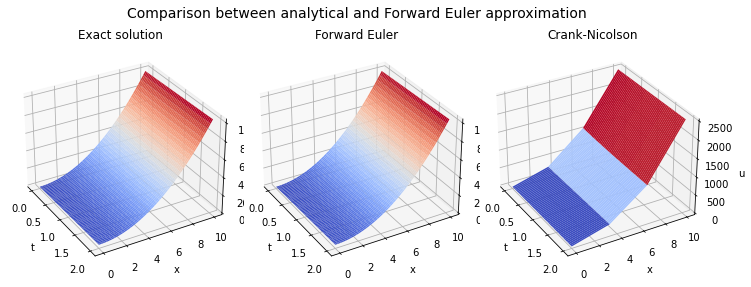

In [782]:
plot_three_solutions(v_exact, v_forward, v_CN, angle=-30, 
                   title1="Exact solution", title2="Forward Euler", title3="Crank-Nicolson",
                   title="Comparison between analytical and Forward Euler approximation")

and they seem to look good.

## CFL-TESTING

We have in our derivation for the monotonicity of our methods, that we needed certain requirements related to our constants. Let us inspect what happens when these requirements are not fulfilled for the forward euler method. Recall that our CFL condition was that $\xi_m = 1- k \sigma^2 m^2 - kc \geq 0, \quad m=1, \dots, M-1$. The monotonicity guarantees stability, and if the requirement is unsatisfied, this is no longer guaranteed.

We first want to check what happens when the CFL condition $\xi_m = 1- k \sigma^2 m^2 - kc \geq 0$ doesn't hold. For example, we can let $\sigma=1/4$ instead of $1/5$ such that the left hand side is negative.

In [682]:
sigma=1/4

The quantity /xi_m gains a minimum at -0.227


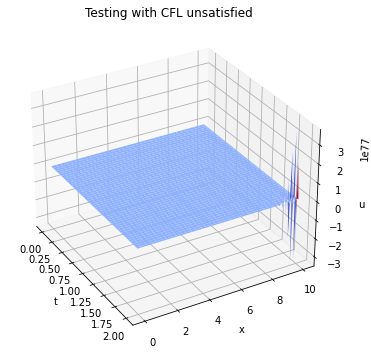

In [686]:
v_forward_CFL, CFL_forward_CFL = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
plot_solution(v_forward_CFL, angle=-30, title="Testing with CFL unsatisfied")
print("The quantity /xi_m gains a minimum at", round(CFL_forward_CFL, 3))

We see that the result is drastic.

## CONVERGENCE RATES

We now want to see what happens with the error $e(h, k)= U - u$ when we vary $h$. In that way, we can find the convergence rate. First, we simply want to inspect $e(h,k)$ with a fixed $k$, so we let $k$ stand as it is. We define an array of $h$'s (and $M$'s).

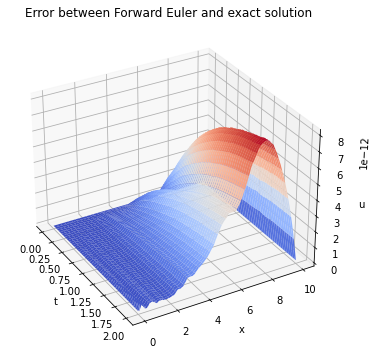

In [784]:
plot_solution(v_forward - v_exact , angle=-30, title="Error between Forward Euler and exact solution")

In [ ]:
def convergence_order(u_exact, method=forward_euler): 
    P = 10
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 2
    for p in range(P):
        x, t, U = solver(g, M=M, N=10000, T=0.1)
        Eh = u_exact(x,t[-1])-U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

To evaluate the error for a particular $h$, it is reasonable to assume that the error is greatest at $t=T=2$. For evaluating the error, we thus look at the 2-norm error between the exact solution and the numerical solution at $t=2$. We define a function who find the error between two solutions:

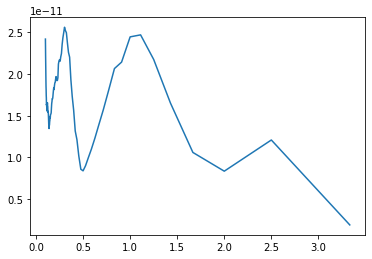

In [756]:
#Define an error function for a method
def error_func(method, exact_method):
    Ms=np.arange(100,2,-1)
    hs=R/Ms
    t=np.linspace(0, T, N+1)
    error= np.zeros(len(hs))
    for i in range(len(Ms)):
        u_numeric, temp = method(R, Ms[i], T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                           an_initial, RHS_func=RHS_analytic)
        x=np.linspace(0, R, Ms[i]+1)
        tt, xx = np.meshgrid(t,x)
        u_analytic = exact_method(tt, xx)
        error[i] = la.norm(u_numeric[:,-1] - u_analytic[:,-1]) #assume 2-norm
    
    return hs, error

hs, error_forward = error_func(forward_euler, v_exact_func)

plt.plot(hs, error_forward)
plt.show()


### Error as function of time

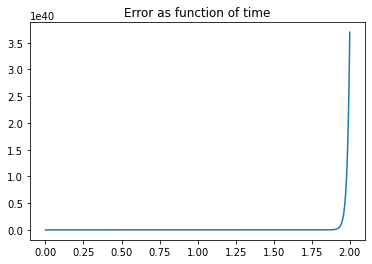

In [597]:
def error_func(u_numeric, u_analytic):
    error= np.zeros(len(u_numeric[0]))
    for i in range(len(error)):
        error[i] = la.norm(u_numeric[:,i] - u_analytic[:,i] ) #Assume 2-norm
    return error

error_forward_euler = error_func(u_exact, u_an)
plt.title("Error as function of time")
plt.plot(t, error_forward_euler)
plt.show()